#  Parallel Iris loads

Exploring using dask delayed and dask bag when loading datasets using Iris.

In [2]:
import glob
import os

from dask import bag as db
from dask import delayed
from distributed import Client
from distributed.security import Security
import iris

Set up scheduler

In [3]:
scheduler = 'tls://10.154.1.83:33881'
sec = Security(tls_ca_file=os.path.expanduser('~/.ssl/ca_cert.pem'),
               tls_client_cert=os.path.expanduser('~/.ssl/server_cert.pem'),
               tls_client_key=os.path.expanduser('~/.ssl/server_key.pem'),
               require_encryption=True)

In [4]:
c = Client(scheduler, security=sec)

Load data...

In [53]:
fp = '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z'
files = glob.glob(os.path.join(fp, 'EURO4_2015060*.pp'))
files

['/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150605.pp',
 '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150606.pp',
 '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150604.pp',
 '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150603.pp',
 '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150601.pp',
 '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150608.pp',
 '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150602.pp',
 '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150607.pp',
 '/project/euro4_hindcast/WIND-ATLAS_EURO4-RERUN/2015/06/18Z/EURO4_20150609.pp']

In [54]:
fp2 = '/project/seasonal/seaice/HadGEM2/akhka.000001'
files2 = glob.glob(os.path.join(fp2, '000001000000.02.00.149.000128*.pp'))
len(files2)

1428

## Part 1: bag

In [63]:
res = db.from_sequence(files2).map(iris.load_cube)

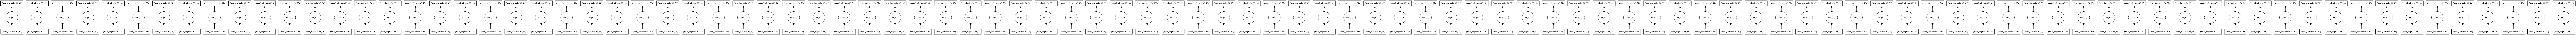

In [64]:
res.visualize()

In [65]:
res

dask.bag<map-loa..., npartitions=102>

In [66]:
cube = iris.cube.CubeList(res.compute()).merge_cube()
print cube

northward_sea_ice_velocity / (m s-1) (time: 1428; latitude: 215; longitude: 360)
     Dimension coordinates:
          time                            x               -               -
          latitude                        -               x               -
          longitude                       -               -               x
     Auxiliary coordinates:
          forecast_period                 x               -               -
     Scalar coordinates:
          forecast_reference_time: 1859-09-01 00:00:00
     Attributes:
          STASH: m02s00i149
          source: Data from Met Office Unified Model
          um_version: 6.6
     Cell methods:
          mean: time (1 hour)


## Part 2: delayed

In [55]:
def merge(l):
    cl = iris.cube.CubeList(l)
    return cl.merge_cube()

In [61]:
res = []
for pp_file in files2:
    cube = delayed(iris.load_cube)(pp_file)
    res.append(cube)

merged = delayed(merge)(res)

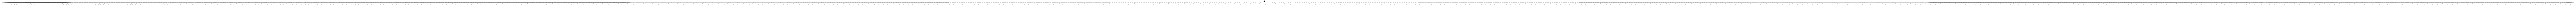

In [59]:
merged.visualize()

In [62]:
merged.compute()

<iris 'Cube' of northward_sea_ice_velocity / (m s-1) (time: 1428; latitude: 215; longitude: 360)>